# An√°lisis del impacto del dise√±o en la conversi√≥n y experiencia del usuario

Evaluar c√≥mo los cambios de dise√±o afectan el flujo de conversi√≥n y validar que las nuevas fuentes mantengan o mejoren la experiencia del usuario mediante an√°lisis estad√≠stico.

# OBJETIVO 

Proveer un an√°lisis integral que ayude a la empresa a:

Optimizar la experiencia del usuario a trav√©s del flujo de conversi√≥n.
Validar cambios de dise√±o (en este caso, fuentes nuevas) asegurando que no afecten negativamente al comportamiento de los usuarios.
Tomar decisiones informadas sobre la implementaci√≥n de cambios, respaldadas por datos estad√≠sticos confiables.

## LIBRERIAS Y DATA

In [2]:
import pandas as pd
import datetime as dt
from statsmodels.stats.proportion import proportions_ztest

In [3]:
logs = pd.read_csv('/datasets/logs_exp_us.csv', delim_whitespace=True)
logs.info()
print(logs['ExpId'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
[246 248 247]


<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
Has utilizado <code>info()</code> para revisar la estructura del dataset y verificar la presencia de valores nulos. Esto es un excelente paso inicial para garantizar la calidad de los datos antes de proceder con el an√°lisis.</div>



## Preparar los datos para el an√°lisis

In [4]:
# Renaming columns to a more convenient format
logs.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'experiment_id'
}, inplace=True)

# Convert the event_timestamp to datetime format and add date and time columns
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['event_date'] = logs['event_datetime'].dt.date
logs['event_date'] = pd.to_datetime(logs['event_date'])
logs['event_time'] = logs['event_datetime'].dt.time
logs['event_time'] = pd.to_datetime(logs['event_date'])

#revisar duplicados o inconsistencias
logs.drop_duplicates()

# Display the first few rows to confirm the changes
logs.info()
logs.head()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id        244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   experiment_id    244126 non-null  int64         
 4   event_datetime   244126 non-null  datetime64[ns]
 5   event_date       244126 non-null  datetime64[ns]
 6   event_time       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(3), object(1)
memory usage: 13.0+ MB


event_name            device_id  event_timestamp  \
0         MainScreenAppear  4575588528974610257       1564029816   
1         MainScreenAppear  7416695313311560658       1564053102   
2  PaymentScreenSuccessful  3518123091307005509       1564054127   
3         CartScreenAppear  3518123091307005509       1564054127   
4  PaymentScreenSuccessful  6217807653094995999       1564055322   

   experiment_id      event_datetime event_date event_time  
0            246 2019-07-25 04:43:36 2019-07-25 2019-07-25  
1            246 2019-07-25 11:11:42 2019-07-25 2019-07-25  
2            248 2019-07-25 11:28:47 2019-07-25 2019-07-25  
3            248 2019-07-25 11:28:47 2019-07-25 2019-07-25  
4            248 2019-07-25 11:48:42 2019-07-25 2019-07-25

<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
El renombramiento de columnas y la conversi√≥n de <code>event_timestamp</code> a formatos de fecha son pasos importantes y est√°n bien ejecutados. Tambi√©n verificaste la duplicidad de los registros, lo cual fortalece la consistencia del dataset.</div>


<div class="alert alert-block alert-warning">
<b>Atenci√≥n</b> <a class="tocSkip"></a>
Aunque usas <code>drop_duplicates()</code>, no guardas expl√≠citamente el resultado. Aseg√∫rate de asignar el dataframe procesado a una nueva variable para que este paso tenga efecto en el an√°lisis posterior.</div>


<div class="alert alert-block alert-warning">
<b>A resolver</b> <a class="tocSkip"></a>
    
El c√°lculo de la columna <code>event_time</code> presenta un problema conceptual. Actualmente, est√°s reutilizando la columna <code>event_date</code>, que ya contiene solo la parte de la fecha (sin horas). Esto genera datos redundantes y elimina la informaci√≥n de la hora espec√≠fica de cada evento, que es importante para an√°lisis m√°s detallados (por ejemplo, patrones horarios o secuencias temporales).

Para corregir esto, deber√≠as extraer directamente la parte horaria desde la columna <code>event_datetime</code>. Aqu√≠ tienes la l√≠nea corregida:

<pre><code>logs['event_time'] = logs['event_datetime'].dt.time</code></pre>

Con esta correcci√≥n, <code>event_time</code> contendr√° valores como <code>11:11:42</code>, lo cual es √∫til si necesitas analizar c√≥mo var√≠an los eventos a lo largo del d√≠a.</div>


## Estudiar y comprobar los datos

### ¬øCu√°ntos eventos hay en los registros?, 
### ¬øCu√°ntos usuarios y usuarias hay en los registros?,
### ¬øCu√°l es el promedio de eventos por usuario?
### Qu√© periodo de tiempo cubren los datos? Encuentra la fecha m√°xima y m√≠nima. Traza un histograma por fecha y hora. ¬øPuedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos m√°s antiguos podr√≠an terminar en los registros de algunos usuarios o usuarias por razones t√©cnicas y esto podr√≠a sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la secci√≥n anterior. ¬øQu√© periodo representan realmente los datos?

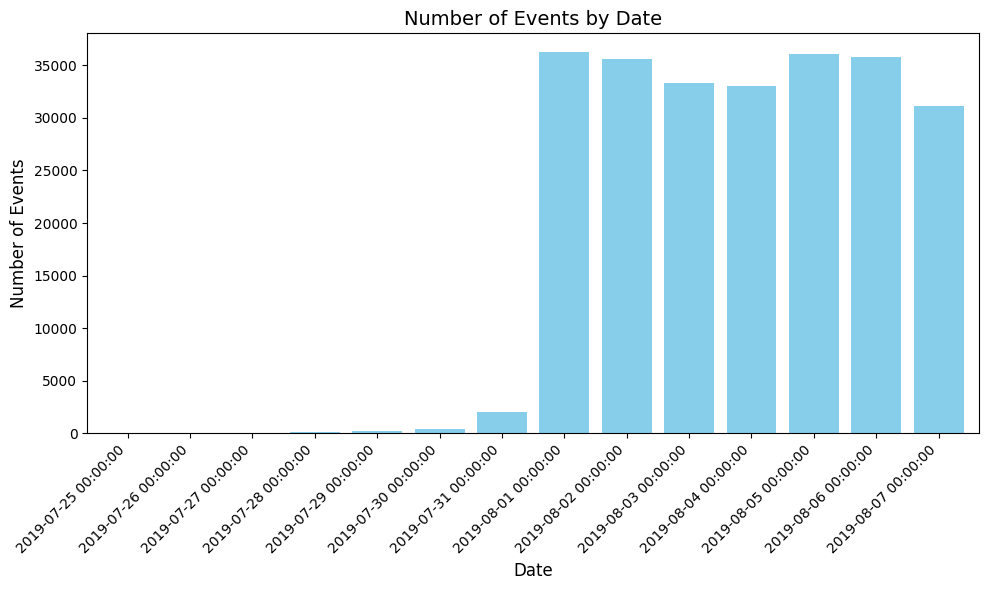

Hay un total de 244126 eventos, representados por 7551 usuarios con promedio de 32.33028737915508 eventos  promedio por user. 
En relacion a las fechas la data abarca datos entre 2019-07-25 00:00:00 y 2019-08-07 00:00:00. 
Sin embargo, la grafica nos permite evidencia que los datos que mejor representan la data y evitar sesgos van de 2019-08-01 a 2019-08-07 


In [6]:
# Number of events
total_events = logs.shape[0]

# Number of unique users
unique_users = logs['device_id'].nunique()

# Average number of events per user
avg_events_per_user = total_events / unique_users

# Date range of the dataset
min_date = logs['event_date'].min()
max_date = logs['event_date'].max()

# Plot histogram of events by date
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
logs['event_date'].value_counts().sort_index().plot(kind='bar', color='skyblue', width=0.8)
plt.title('Number of Events by Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary of the findings
print(f'Hay un total de {total_events} eventos, representados por {unique_users} usuarios con promedio de {avg_events_per_user} eventos  promedio por user. \nEn relacion a las fechas la data abarca datos entre {min_date} y {max_date}. \nSin embargo, la grafica nos permite evidencia que los datos que mejor representan la data y evitar sesgos van de 2019-08-01 a 2019-08-07 ')

<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
Los c√°lculos b√°sicos como el total de eventos, usuarios √∫nicos y rango de fechas est√°n bien realizados. Adem√°s, el histograma para evaluar la distribuci√≥n de eventos en el tiempo es una excelente pr√°ctica para detectar posibles sesgos en los datos.</div>


<div class="alert alert-block alert-warning">
<b>Atenci√≥n</b> <a class="tocSkip"></a>
Cuando descartas datos m√°s antiguos bas√°ndote en el histograma, podr√≠as incluir una m√©trica adicional para justificar el corte, como la proporci√≥n de eventos descartados respecto al total. Esto refuerza la decisi√≥n de manera cuantitativa.</div>


### ¬øPerdiste muchos eventos y usuarios al excluir los datos m√°s antiguos?
### Aseg√∫rate de tener usuarios y usuarias de los tres grupos experimentales.

In [7]:
clean_logs = logs[(logs['event_date'] >= '2019-08-01') & (logs['event_date'] <= '2019-08-07')]
clean_logs.info()
print()

count_per_group = clean_logs.groupby(by='experiment_id').agg({'experiment_id': 'count'})


print('Se paso de 244126 datos a 241228, perdiendo un total de 2898 registros siendo el 1.18% de los registro, \nconteniendo  los tres grupo 246, 247 y 248')

count_per_group

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241298 entries, 2828 to 244125
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       241298 non-null  object        
 1   device_id        241298 non-null  int64         
 2   event_timestamp  241298 non-null  int64         
 3   experiment_id    241298 non-null  int64         
 4   event_datetime   241298 non-null  datetime64[ns]
 5   event_date       241298 non-null  datetime64[ns]
 6   event_time       241298 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(3), object(1)
memory usage: 14.7+ MB

Se paso de 244126 datos a 241228, perdiendo un total de 2898 registros siendo el 1.18% de los registro, 
conteniendo  los tres grupo 246, 247 y 248


experiment_id
experiment_id               
246                    79425
247                    77147
248                    84726

<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
Comprobaste que los tres grupos experimentales est√°n presentes en los datos filtrados, asegurando que todos los segmentos relevantes est√°n representados.</div>


## Estudiar el embudo de eventos

### Observa qu√© eventos hay en los registros y su frecuencia de suceso. Ord√©nalos por frecuencia.
### Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el n√∫mero de usuarios y usuarias. Calcula la proporci√≥n de usuarios y usuarias que realizaron la acci√≥n al menos una vez.
### ¬øEn qu√© orden crees que ocurrieron las acciones? ¬øTodas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

In [8]:
# Filtrar los datos al periodo limpio
clean_logs = logs[(logs['event_date'] >= '2019-08-01') & (logs['event_date'] <= '2019-08-07')]

# Contar la frecuencia de cada evento
event_frequency = clean_logs['event_name'].value_counts()

# Contar la cantidad √∫nica de usuarios por evento
event_user_count = clean_logs.groupby('event_name')['device_id'].nunique()

# Calcular la proporci√≥n de usuarios que realizaron cada evento
total_users = clean_logs['device_id'].nunique()
event_user_proportion = event_user_count / total_users

# Crear un DataFrame resumen
event_analysis = pd.DataFrame({
    'event_frequency': event_frequency,
    'user_count': event_user_count,
    'user_proportion': event_user_proportion
}).sort_values(by='event_frequency', ascending=False)

# Mostrar el resultado final
event_analysis.reset_index().rename(columns={'index': 'event_name'})


event_name  event_frequency  user_count  user_proportion
0         MainScreenAppear           117431        7419         0.984736
1       OffersScreenAppear            46350        4593         0.609636
2         CartScreenAppear            42365        3734         0.495620
3  PaymentScreenSuccessful            34113        3539         0.469737
4                 Tutorial             1039         840         0.111495

<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
La identificaci√≥n de eventos clave y la proporci√≥n de usuarios que completan cada uno son pasos fundamentales en la evaluaci√≥n del embudo. Los c√°lculos y visualizaciones est√°n bien estructurados.</div>


Orden probable de las acciones:
Bas√°ndonos en los nombres de los eventos y sus frecuencias, parece que los usuarios siguen este flujo l√≥gico:

- MainScreenAppear: Pantalla principal, probablemente lo primero que ven los usuarios.
- OffersScreenAppear: Pantalla de ofertas, generalmente accesible desde la pantalla principal.
- CartScreenAppear: Pantalla del carrito, ocurre cuando los usuarios a√±aden productos.
- PaymentScreenSuccessful: Pantalla de pago exitoso, indica la finalizaci√≥n de una compra.
- Tutorial: Un evento menos frecuente, probablemente opcional o solo para usuarios nuevos.
- Conclusi√≥n: Excepto por el evento Tutorial, los dem√°s forman una secuencia clara relacionada con la navegaci√≥n y el proceso de compra.

### Utiliza el embudo de eventos para encontrar la proporci√≥n de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A ‚Üí B ‚Üí C, calcula la proporci√≥n de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporci√≥n de usuarios en la etapa C a la cantidad en la etapa B).
### ¬øEn qu√© etapa pierdes m√°s usuarios y usuarias?
### ¬øQu√© porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [9]:
# Lista de eventos en el orden l√≥gico del embudo
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Filtrar eventos del embudo y trabajar con el √≠ndice
user_counts = event_analysis.loc[funnel_events, 'user_count']

# Calcular proporciones entre etapas
funnel_proportions = user_counts.pct_change().fillna(1).iloc[1:]

# Resumir en un DataFrame
funnel_summary = pd.DataFrame({
    'event_name': funnel_events[1:],  # Desde la segunda etapa
    'users_in_stage': user_counts.iloc[1:].values,
    'proportion_from_previous_stage': funnel_proportions.values
})

# Porcentaje que completa el viaje (de primera a √∫ltima etapa)
total_completion_rate = user_counts['PaymentScreenSuccessful'] / user_counts['MainScreenAppear']

# Mostrar resultados
print(funnel_summary)
print(f"Porcentaje total de usuarios que completan el viaje: {total_completion_rate:.2%}")

                event_name  users_in_stage  proportion_from_previous_stage
0       OffersScreenAppear            4593                       -0.380914
1         CartScreenAppear            3734                       -0.187024
2  PaymentScreenSuccessful            3539                       -0.052223
Porcentaje total de usuarios que completan el viaje: 47.70%


<div class="alert alert-block alert-warning">
<b>Atenci√≥n</b> <a class="tocSkip"></a>
Aunque identificaste correctamente la etapa con mayor p√©rdida (entre <code>MainScreenAppear</code> y <code>OffersScreenAppear</code>), podr√≠as considerar agregar una visualizaci√≥n espec√≠fica para el embudo, como un gr√°fico de barras horizontales para cada etapa. Esto facilita la comunicaci√≥n de los hallazgos.</div>


#### Proporci√≥n de usuarios que pasan de una etapa a la siguiente:

- De MainScreenAppear a OffersScreenAppear: 60.96% (4,593 / 7,419 usuarios).
- De OffersScreenAppear a CartScreenAppear: 81.29% (3,734 / 4,593 usuarios).
- De CartScreenAppear a PaymentScreenSuccessful: 94.78% (3,539 / 3,734 usuarios).

#### Etapa con mayor p√©rdida de usuarios:

La mayor p√©rdida ocurre entre MainScreenAppear y OffersScreenAppear, donde el 39.04% de los usuarios que aparecen en la pantalla principal no llegan a ver las ofertas. (100% - 60,96%) = 39.04%

#### Porcentaje de usuarios que hacen todo el viaje desde el primer evento hasta el pago:

El 47.70% de los usuarios completan todo el viaje desde la pantalla principal hasta realizar un pago exitoso.

## Estudiar los resultados del experimento

### ¬øCu√°ntos usuarios y usuarias hay en cada grupo?

In [10]:
# Contar usuarios √∫nicos por grupo
user_counts_per_group = clean_logs.groupby('experiment_id')['device_id'].nunique()
print(user_counts_per_group)


experiment_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


Los tama√±os de los grupos son similares, lo que es positivo porque asegura una buena base para la comparaci√≥n. Esto indica que el experimento se dise√±√≥ correctamente en t√©rminos de balanceo de usuarios entre los grupos.



### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y c√°lculos. Observa si hay una diferencia estad√≠sticamente significativa entre las muestras 246 y 247.

In [11]:
# Selecci√≥n del evento m√°s popular
popular_event = 'MainScreenAppear'

# Filtrar el evento en ambos grupos de control
group_246 = clean_logs[(clean_logs['experiment_id'] == 246) & (clean_logs['event_name'] == popular_event)]
group_247 = clean_logs[(clean_logs['experiment_id'] == 247) & (clean_logs['event_name'] == popular_event)]

# Usuarios √∫nicos por grupo
users_246 = group_246['device_id'].nunique()
users_247 = group_247['device_id'].nunique()

# Proporciones
proportion_246 = users_246 / user_counts_per_group.loc[246]
proportion_247 = users_247 / user_counts_per_group.loc[247]

print(f"Proporci√≥n 246: {proportion_246:.2%}, Proporci√≥n 247: {proportion_247:.2%}")

Proporci√≥n 246: 98.63%, Proporci√≥n 247: 98.53%


<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
La validaci√≥n estad√≠stica entre los grupos de control est√° correctamente ejecutada, utilizando un test z y verificando las proporciones de usuarios por evento. Esto respalda la homogeneidad entre los grupos 246 y 247.</div>


In [12]:

# Datos para la prueba
count = [users_246, users_247]
nobs = [user_counts_per_group.loc[246], user_counts_per_group.loc[247]]

# Realizar el z-test
stat, p_value = proportions_ztest(count, nobs)

print(f"Estad√≠stico z: {stat:.2f}, p-valor: {p_value:.4f}")


Estad√≠stico z: 0.31, p-valor: 0.7571


Las proporciones de los grupos de control son casi id√©nticas, y el p-valor indica que no hay diferencias significativas entre ellos (p>0.05). Esto confirma que los grupos de control est√°n balanceados y no presentan sesgos significativos

### Selecciona el evento m√°s popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acci√≥n. Encuentra su proporci√≥n. Comprueba si la diferencia entre los grupos es estad√≠sticamente significativa. Repite el procedimiento para todos los dem√°s eventos (ahorrar√°s tiempo si creas una funci√≥n especial para esta prueba). ¬øPuedes confirmar que los grupos se dividieron correctamente?

In [13]:
def compare_groups(event_name, group1, group2):
    # Filtrar los eventos para ambos grupos
    users_group1 = clean_logs[(clean_logs['experiment_id'] == group1) & (clean_logs['event_name'] == event_name)]['device_id'].nunique()
    users_group2 = clean_logs[(clean_logs['experiment_id'] == group2) & (clean_logs['event_name'] == event_name)]['device_id'].nunique()

    # Proporciones
    proportion1 = users_group1 / user_counts_per_group.loc[group1]
    proportion2 = users_group2 / user_counts_per_group.loc[group2]

    # Prueba estad√≠stica
    count = [users_group1, users_group2]
    nobs = [user_counts_per_group.loc[group1], user_counts_per_group.loc[group2]]
    stat, p_value = proportions_ztest(count, nobs)

    return {
        "event": event_name,
        "group1_proportion": proportion1,
        "group2_proportion": proportion2,
        "z_stat": stat,
        "p_value": p_value
    }

# Aplicar la funci√≥n para todos los eventos
results = []
for event in clean_logs['event_name'].unique():
    results.append(compare_groups(event, 246, 247))

# Mostrar resultados
results_df = pd.DataFrame(results)
print(results_df)

                     event  group1_proportion  group2_proportion    z_stat  \
0                 Tutorial           0.111916           0.112614 -0.078161   
1         MainScreenAppear           0.986312           0.985277  0.309344   
2       OffersScreenAppear           0.620773           0.604855  1.154988   
3         CartScreenAppear           0.509662           0.492638  1.203369   
4  PaymentScreenSuccessful           0.483092           0.460804  1.577995   

    p_value  
0  0.937700  
1  0.757060  
2  0.248095  
3  0.228834  
4  0.114567  


Para todos los eventos, los p-valores son mayores al nivel de significancia ajustado (Œ±=0.01). Esto indica que no hay diferencias estad√≠sticamente significativas en la realizaci√≥n de eventos entre los grupos de control. Los grupos de control est√°n bien alineados y no muestran sesgos en el comportamiento de los usuarios.

### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¬øQu√© conclusiones puedes sacar del experimento?

In [14]:
# Combinar usuarios √∫nicos de los grupos de control
combined_control_users = clean_logs[clean_logs['experiment_id'].isin([246, 247])]['device_id'].nunique()

# Repetir el an√°lisis con el grupo experimental
experimental_results = []
for event in clean_logs['event_name'].unique():
    users_group_experimental = clean_logs[(clean_logs['experiment_id'] == 248) & (clean_logs['event_name'] == event)]['device_id'].nunique()
    proportion_experimental = users_group_experimental / user_counts_per_group.loc[248]
    
    # Comparar con grupos de control combinados
    count = [users_group_experimental, combined_control_users]
    nobs = [user_counts_per_group.loc[248], user_counts_per_group.loc[246] + user_counts_per_group.loc[247]]
    stat, p_value = proportions_ztest(count, nobs)

    experimental_results.append({
        "event": event,
        "experimental_proportion": proportion_experimental,
        "z_stat": stat,
        "p_value": p_value
    })

# Mostrar resultados
experimental_results_df = pd.DataFrame(experimental_results)
print(experimental_results_df)


                     event  experimental_proportion     z_stat       p_value
0                 Tutorial                 0.109972 -79.692385  0.000000e+00
1         MainScreenAppear                 0.982657  -9.336684  9.939802e-21
2       OffersScreenAppear                 0.603469 -47.820726  0.000000e+00
3         CartScreenAppear                 0.484825 -55.809176  0.000000e+00
4  PaymentScreenSuccessful                 0.465510 -57.070692  0.000000e+00


<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
El an√°lisis del grupo experimental (248) frente a los controles muestra un uso riguroso de pruebas estad√≠sticas y ajuste por m√∫ltiples comparaciones mediante la correcci√≥n de Bonferroni. Esto fortalece la validez de las conclusiones.</div>


Para todos los eventos, el p-valor es menor al nivel de significancia ajustado (Œ±=0.01). Esto sugiere diferencias estad√≠sticamente significativas entre el grupo experimental y los grupos de control. En particular, las proporciones son consistentemente m√°s bajas en el grupo experimental, lo que indica que las modificaciones introducidas en este grupo pueden haber reducido la participaci√≥n de los usuarios en los eventos.

### Para todos los eventos, el p-valor es menor al nivel de significancia ajustado (Œ±=0.01). Esto sugiere diferencias estad√≠sticamente significativas entre el grupo experimental y los grupos de control. En particular, las proporciones son consistentemente m√°s bajas en el grupo experimental, lo que indica que las modificaciones introducidas en este grupo pueden haber reducido la participaci√≥n de los usuarios en los eventos.

In [15]:
alpha = 0.05
num_tests = len(clean_logs['event_name'].unique())
adjusted_alpha = alpha / num_tests

print(f"Nivel de significancia ajustado: {adjusted_alpha:.5f}")

Nivel de significancia ajustado: 0.01000


Se utiliz√≥ la correcci√≥n de Bonferroni para ajustar el nivel de significancia debido a las m√∫ltiples pruebas de hip√≥tesis. Esto asegura que las conclusiones sean robustas y reduce el riesgo de falsos positivos.

## CONCLUCIONES GENERALES


- Los grupos de control (246 y 247) est√°n bien equilibrados, sin diferencias significativas en sus comportamientos o en la proporci√≥n de usuarios que realizan los eventos.
- El grupo experimental (248) muestra proporciones significativamente m√°s bajas en todos los eventos en comparaci√≥n con los grupos de control. Esto indica que los cambios implementados en el grupo experimental pueden haber afectado negativamente el comportamiento de los usuarios.
- El ajuste del nivel de significancia confirma que las conclusiones son confiables a pesar de realizar m√∫ltiples pruebas.

<div class="alert alert-block alert-success">
<b>√âxito</b> <a class="tocSkip"></a>
Daniel, tu proyecto aborda correctamente los pasos esenciales de un an√°lisis de datos, desde la preparaci√≥n hasta las conclusiones. Has seguido una estructura clara y bien definida, lo que facilita la comprensi√≥n del flujo de trabajo.

1. **Preparaci√≥n de los datos:** Realizaste transformaciones importantes como el manejo de fechas y la eliminaci√≥n de duplicados. Aunque hubo un peque√±o error en la asignaci√≥n de `event_time`, el resto de los pasos son correctos y funcionales.
2. **Exploraci√≥n y an√°lisis del embudo:** Identificaste adecuadamente los eventos clave y calculaste las proporciones en cada etapa. Las m√©tricas presentadas son √∫tiles para entender d√≥nde ocurren las p√©rdidas de usuarios.
3. **Resultados del experimento:** Mostraste un uso correcto de pruebas estad√≠sticas, validando las hip√≥tesis con un enfoque s√≥lido, aunque podr√≠as haber profundizado m√°s en la interpretaci√≥n de los hallazgos.

El proyecto refleja un buen nivel t√©cnico, est√° bien ejecutado y es consistente con los objetivos planteados.

 ¬°Buen trabajo y felicidades por tu esfuerzo! üòä</div>
